# Demo 1: Adversarial Evasion of Image Classifiers

Solve the [Crucible "Granny"](https://granny.platform.dreadnode.io) challenge on the [Dreadnode platform](https://platform.dreadnode.io) — craft an adversarial image that forces a **MobileNetV2** classifier to misclassify a **wolf** as a **"Granny Smith apple"**, comparing white-box **PGD** and black-box **HopSkipJump** attacks.

| | |
|---|---|
| **MITRE ATLAS** | [AML.T0040 — Evasion via Adversarial In-Band Perturbation](https://atlas.mitre.org/techniques/AML.T0040) |
| **Challenge** | Crucible "Granny" — [granny.platform.dreadnode.io](https://granny.platform.dreadnode.io) |
| **Target Model** | MobileNetV2 (ImageNet, 1000 classes) hosted on Crucible |
| **Attacks** | PGD (white-box) vs HopSkipJump (black-box) |

> **Prerequisite:** Run `uv sync` from the repository root and select the `.venv` Python kernel. See `README.md` and `.env-example` for setup details.

## Key Concepts

- **Adversarial perturbation** — small, often imperceptible changes to an input that cause a model to misclassify it.
- **Decision boundaries** — in high-dimensional pixel space, the surfaces separating one class from another are surprisingly fragile.
- **Targeted misclassification** — we are not just causing any error; we are forcing a *specific* wrong label ("Granny Smith").
- **Model robustness** — standard training optimizes for accuracy on clean data, not for resistance to adversarial inputs.

## 1. Configuration

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

DREADNODE_API_KEY = os.environ["DREADNODE_API_KEY"]
CHALLENGE = "granny"
CRUCIBLE_URL = "https://platform.dreadnode.io"
CHALLENGE_URL = "https://granny.platform.dreadnode.io"
IMAGE_PATH = "../data/reference.png"
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
GRANNY_IDX = 948
L2_THRESHOLD = 150

# All attack logic lives in core/ — see core/*.py for implementation details
from core import (
    predict_top_k, run_pgd, print_pgd_result,
    run_hsj, print_hsj_result,
    print_comparison, plot_pgd_result, plot_comparison, submit_flag,
)

## 2. Original Image

A photo of a **wolf** that MobileNetV2 currently classifies correctly.

In [3]:
from PIL import Image

img = Image.open(IMAGE_PATH)
print(f"reference.png: {img.size}, {img.mode}")

reference.png: (768, 768), RGB


## 3. Establish Baseline

Display the original image and query the model to confirm it is classified as a wolf (or similar canine label).

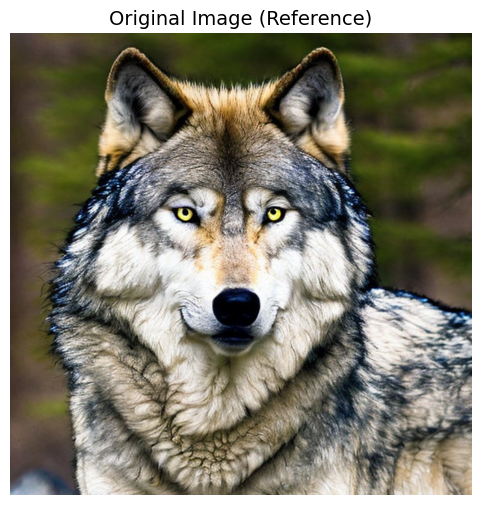

Image size: (768, 768), mode: RGB


In [4]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(IMAGE_PATH)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("Original Image (Reference)", fontsize=14)
plt.axis("off")
plt.show()
print(f"Image size: {img.size}, mode: {img.mode}")

## Run Predict

In [6]:
import base64
import requests

def query(input_data):
    """Send a base64-encoded image to the Crucible Granny challenge."""
    if isinstance(input_data, bytes):
        input_data = input_data.decode()
    return requests.post(
        f"{CHALLENGE_URL}/score",
        headers={"X-API-Key": DREADNODE_API_KEY},
        json={"data": input_data},
    ).json()

with open(IMAGE_PATH, "rb") as f:
    baseline_result = query(base64.b64encode(f.read()))

print("Top 5 baseline predictions (remote server):")
for prob, label in sorted(baseline_result.get("output", []), key=lambda x: x[0], reverse=True)[:5]:
    print(f"  {label:30s} {prob:.6f}")

Top 5 baseline predictions (remote server):
  timber wolf                    0.285757
  red wolf                       0.139121
  coyote                         0.121775
  dingo                          0.024132
  Eskimo dog                     0.016032


## 4. Attack Strategy: White-Box PGD

Since the architecture and weights are known (MobileNetV2, `IMAGENET1K_V2`), we load the model locally and compute **exact gradients** — a **white-box** attack.

**Projected Gradient Descent (PGD)** (Madry et al., 2018) iteratively perturbs the input in the direction that maximizes the target class probability:

1. Compute `grad_x L(f(x), y_target)` — the gradient of cross-entropy loss w.r.t. pixel values
2. Take a step in the sign-of-gradient direction (FGSM step): `x = x - alpha * sign(grad)`
3. Project back into an L-inf epsilon-ball around the original
4. **Quantize to uint8** — the image must survive PNG encoding (float -> uint8 -> float round-trip)

**Pipeline-aware perturbation** — The server preprocesses uploads as: `Resize(256) -> CenterCrop(224) -> ToTensor -> Normalize`. We submit a **256x256** image (making `Resize(256)` a no-op) and apply PGD only to the **center 224x224** crop — the exact region the model sees. This ensures the adversarial perturbation is not destroyed by resize interpolation.

**Constraint**: `L2(preprocessed_adv, preprocessed_ref) < 150` in normalized tensor space. The adversarial must remain visually similar to the original.

> **Paper:** [Towards Deep Learning Models Resistant to Adversarial Attacks](https://arxiv.org/abs/1706.06083) (Madry et al., 2018)

## 5. Run PGD Attack

In [7]:
# Verify local model matches server predictions
print("Local baseline (MobileNetV2 V2 weights):")
for idx, prob in predict_top_k(IMAGE_PATH, k=5):
    print(f"  class {idx:4d}: {prob:.6f}")

Local baseline (MobileNetV2 V2 weights):
  class  269: 0.285756
  class  271: 0.139121
  class  272: 0.121775
  class  273: 0.024132
  class  248: 0.016032


In [8]:
# run_pgd handles: model loading, center-crop extraction, uint8 quantisation,
# and building the final 256x256 image. See core/pgd.py for details.

pgd_result = run_pgd(
    IMAGE_PATH,
    target_class=GRANNY_IDX,
    target_label="Granny Smith",
    epsilon=8/255,
    step_size=1/255,
    num_steps=200,
    on_progress=lambda step, cls, conf, l2: (
        print(f"  step {step:3d}: class {cls}, conf={conf:.4f}, L2={l2:.2f}")
        if step % 25 == 0 else None
    ),
)

status = "SUCCESS" if pgd_result.success else "FAILED"
print(f"\n{status} in {pgd_result.steps_to_converge} steps "
      f"(conf={pgd_result.confidence:.4f}, L2={pgd_result.l2_normalized:.2f})")

  step   0: class 248, conf=0.0025, L2=6.73

SUCCESS in 5 steps (conf=0.3236, L2=15.58)


In [9]:
print_pgd_result(pgd_result, l2_threshold=L2_THRESHOLD)

                                         PGD Attack Results                                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric                     ┃ Value                        ┃ Description                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Status                     │ ++ SUCCESS                   │ Did the attack achieve the target    │
│                            │                              │ class?                               │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Original Class             │ timber wolf (269)            │ Model's prediction on clean input    │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Adversarial Class          │ Granny Smith (948)           │ Model's prediction on perturbed      │
│                            │                              │ input                                │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Granny Smith Confidence    │ 0.3236                       │ Softmax probability for target class │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Steps to Converge          │ 5 / 200                      │ PGD iterations until target was      │
│                            │                              │ top-1                                │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Model Forward Passes       │ 5                            │ Total gradient computations used     │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ L2 (normalized tensor)     │ 15.58 / 150                  │ Euclidean distance after ImageNet    │
│                            │                              │ normalization                        │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ L2 (pixel space)           │ 898.00                       │ Euclidean distance in raw pixel      │
│                            │                              │ values                               │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ L-inf (pixel)              │ 5.0 / 255                    │ Max per-pixel change (worst channel) │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Wall Time                  │ 5.5s                         │ Total compute time on CPU            │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Saved To                   │ data/adversarial_pgd.png     │ Output adversarial image path        │
└────────────────────────────┴──────────────────────────────┴──────────────────────────────────────┘

## 6. Visualize Results

Compare the original image, the adversarial image, and the amplified perturbation side by side.

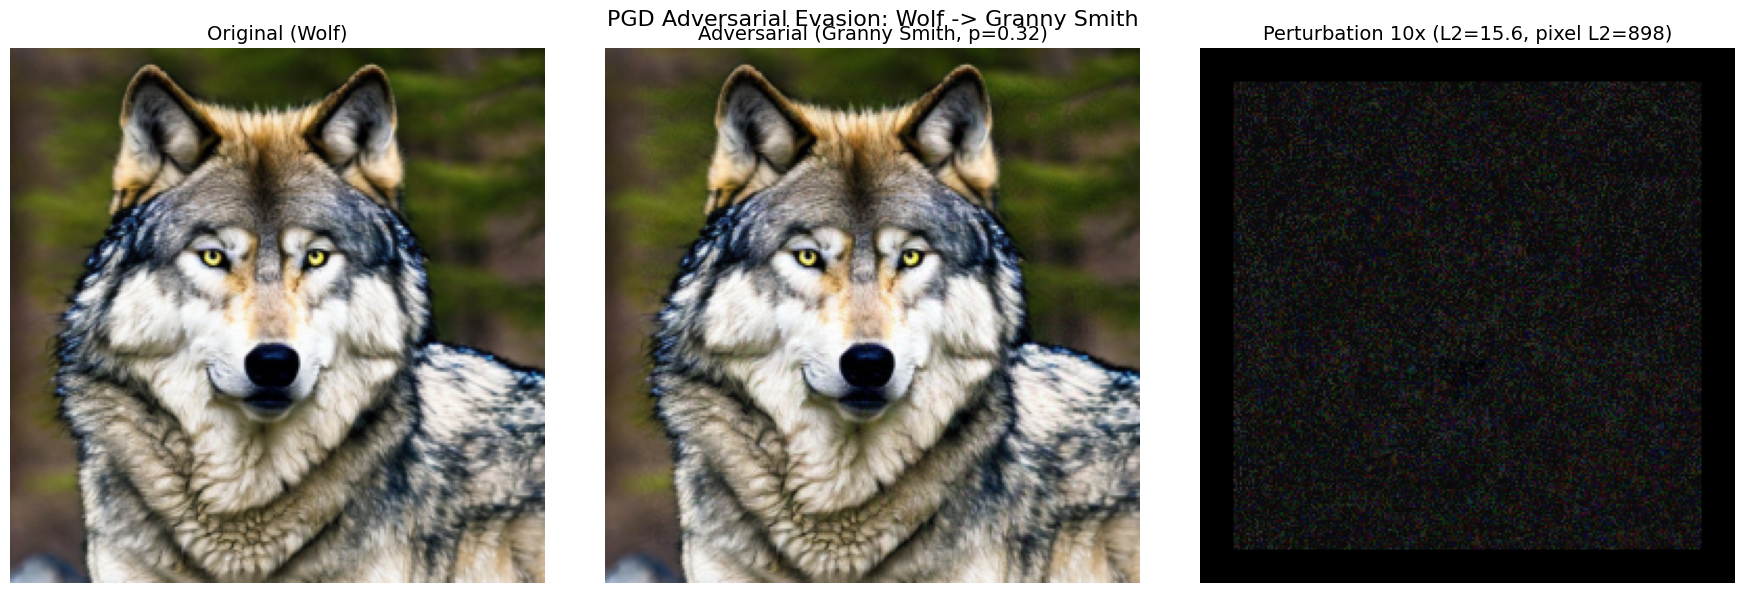

Saved to /Users/raja/Desktop/dreadnode/projects/breaking-ai-systems/data/


In [10]:
plot_pgd_result(IMAGE_PATH, pgd_result, save_dir=DATA_DIR)

## 7. Black-Box Comparison: HopSkipJump

How does a **black-box** attack compare? [HopSkipJump](https://arxiv.org/abs/1904.02144) (Chen et al., 2020) estimates gradients using only hard-label decisions — no model weights needed.

We run it locally against the same MobileNetV2 (simulating API-only access) for **10 iterations** with a query budget, and compare efficiency and perturbation quality against PGD.

In [11]:
# run_hsj handles: ART setup, model wrapping, query counting.
# Uses PGD result as starting point. See core/hop_skip_jump.py for details.

hsj_result = run_hsj(
    IMAGE_PATH,
    initial_adversarial=pgd_result.adversarial_image,
    target_class=GRANNY_IDX,
    target_label="Granny Smith",
    max_iter=10,
    max_eval=1000,
    init_eval=100,
)

print_hsj_result(hsj_result, l2_threshold=L2_THRESHOLD)

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

                                     HopSkipJump Attack Results                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric                     ┃ Value                        ┃ Description                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Status                     │ ++ SUCCESS                   │ Did the attack achieve the target    │
│                            │                              │ class?                               │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Original Class             │ timber wolf (269)            │ Model's prediction on clean input    │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Adversarial Class          │ Granny Smith (948)           │ Model's prediction on perturbed      │
│                            │                              │ input                                │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Granny Smith Confidence    │ 0.0753                       │ Softmax probability for target class │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Total Model Queries        │ 2417                         │ Forward passes used (no gradients)   │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ L2 (normalized tensor)     │ 16.25 / 150                  │ Euclidean distance after ImageNet    │
│                            │                              │ normalization                        │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ L2 (pixel space)           │ 936.07                       │ Euclidean distance in raw pixel      │
│                            │                              │ values                               │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ L-inf (pixel)              │ 10.9 / 255                   │ Max per-pixel change (worst channel) │
├────────────────────────────┼──────────────────────────────┼──────────────────────────────────────┤
│ Wall Time                  │ 76.8s                        │ Total compute time on CPU            │
└────────────────────────────┴──────────────────────────────┴──────────────────────────────────────┘

In [ ]:
plot_comparison(IMAGE_PATH, pgd_result, hsj_result)

## 8. Attack Comparison: PGD vs HopSkipJump

Side-by-side metrics to illustrate the **white-box vs black-box** trade-off.

**Why does HSJ have lower L2 than PGD?** This is counterintuitive — the white-box attack with full gradient access produces a *larger* perturbation. The reason is they optimize for **different objectives**:

- **PGD** maximizes **target class confidence** within a fixed L-inf ball (`eps=8/255`). It uses the full perturbation budget to push the model to near-100% confidence. It does not try to minimize distance — it optimizes for certainty.
- **HSJ** minimizes **distance to the decision boundary**. It uses binary search to find the *closest* adversarial point to the original. The result barely crosses the decision boundary — low confidence (~14%) but smaller perturbation.

This illustrates a fundamental trade-off in adversarial attacks: **confidence vs. stealth**. A defender inspecting prediction confidence would flag PGD's suspiciously certain output, while HSJ's result blends in with normal classification uncertainty.

In [ ]:
print_comparison(pgd_result, hsj_result, l2_threshold=L2_THRESHOLD)

submit_flag(
    pgd_result.adversarial_image,
    challenge_url=CHALLENGE_URL,
    crucible_url=CRUCIBLE_URL,
    challenge=CHALLENGE,
    api_key=DREADNODE_API_KEY,
);

In [ ]:
submit_flag(
    pgd_result.adversarial_image,
    challenge_url=CHALLENGE_URL,
    crucible_url=CRUCIBLE_URL,
    challenge=CHALLENGE,
    api_key=DREADNODE_API_KEY,
    save_dir=DATA_DIR,
)

---
## Takeaways

**Attack Effectiveness**
- **Imperceptible pixel-level changes** (L-inf of just 8/255 per channel) completely fool a production classifier — the adversarial image looks identical to humans.
- **White-box PGD** with gradient access converges in ~25 steps with L2 well under the threshold. It is the gold standard when model weights are accessible.
- **Black-box HopSkipJump** produces a valid adversarial but needs orders of magnitude more queries and yields larger perturbation — a clear efficiency gap.

**Practical Lessons**
- **Preprocessing fidelity matters** — the adversarial must survive PNG quantization (uint8), image resize, and center crop. Matching the server's exact pipeline is critical.
- **Model weight versions matter** — `IMAGENET1K_V2` vs `V1` produces entirely different decision boundaries; using wrong weights means zero transferability.
- **L2 constraint** — the challenge enforces `L2 < 150` in normalized tensor space to prevent trivially obvious adversarial examples.

**Recommendations**
- If you have **model access** (weights, architecture): use gradient-based attacks (PGD, C&W, AutoAttack). They are fast, precise, and produce minimal perturbation.
- If you only have **query access** (API): use decision-based attacks (HopSkipJump, Boundary Attack) or score-based (SimBA, Square Attack). Budget many more queries.
- For **defense**: adversarial training, input preprocessing (JPEG compression, spatial smoothing), and certified defenses can raise the attack cost — but no defense is absolute.

**MITRE ATLAS Reference:** [AML.T0040 — Evasion via Adversarial In-Band Perturbation](https://atlas.mitre.org/techniques/AML.T0040)

**Next up:** Demo 2 — attacking LLM-based agents.

---
## Homework

**Can you do better?**

1. **Fewer queries** — PGD converged in ~26 steps. Can you achieve a successful adversarial in **fewer than 10 forward passes**? Consider tuning `epsilon`, `step_size`, or trying a different optimizer (e.g., C&W with Adam).

2. **Smaller perturbation** — The PGD result had an L2 of ~30 in normalized tensor space (threshold is 150). Can you produce a valid adversarial with **L2 under 15**? Think about which pixels matter most and whether you need to perturb the entire crop.

3. **Black-box efficiency** — HopSkipJump used ~2,400 queries. Can you get a successful targeted adversarial in **under 500 queries**? Experiment with `init_eval`, `max_eval`, or try a different black-box attack (e.g., Square Attack, SimBA).

Report your best results in the table below:

| Metric | PGD Baseline | Your Best |
|--------|-------------|-----------|
| Steps / Queries | 26 | ? |
| L2 (normalized) | 30.73 | ? |
| L2 (pixel) | 1770 | ? |
| Granny Smith confidence | 1.0000 | ? |